3D slicc preprocessing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from dipy.io.image import load_nifti
import pandas as pd
import sklearn.cluster
import skimage.segmentation
#from fast_slic import Slic
from skimage.segmentation import mark_boundaries
from skimage.color import gray2rgb
from skimage.filters import threshold_otsu
from skimage.filters import median
from skimage.color import rgb2gray
from scipy.stats import ttest_ind, norm

In [2]:
def evaluate_segmentation(seg_hat_flat, seg_flat, tumor_label):
    #coordinates of predicted and actual tumor
    y_coors = np.argwhere(seg_flat!=0) #mask 

    yhat_coors = np.argwhere(seg_hat_flat ==tumor_label) #prediction 

    #size of tumor and non-tumor (number of voxels)
    tumor_size=len(y_coors)
    total_size = len(seg_flat)
    non_tumor_size = total_size-tumor_size


    #true positive
    correct_id_tumor = np.intersect1d(y_coors, yhat_coors)

    
    
    percent_tumor_correct = len(correct_id_tumor)/tumor_size

    #false positive
    false_positive_points = np.setdiff1d(yhat_coors, y_coors)
    false_positive = len(false_positive_points)/non_tumor_size

    #false negative
    false_neg_points = np.setdiff1d(y_coors, yhat_coors)
    false_neg = len(false_neg_points)/tumor_size

    
    #true negative
    true_negative=(total_size-(tumor_size+len(false_positive_points)))/non_tumor_size

    #Total error (misidentification
    total_incorrect_points = np.concatenate((false_neg_points, false_positive_points))
    total_error = len(total_incorrect_points)/total_size
    
    #percentage of yhat that is correct
    yhat_size = len(yhat_coors)
    correct_id_tumor_hat = np.intersect1d(yhat_coors, y_coors)
    specificity = len(correct_id_tumor_hat)/yhat_size
    
    #New metric, TP + specificity
    metric = (percent_tumor_correct + specificity)/2
    
    
    #Jaccard Loss - intersection over union
    intersect =np.intersect1d(yhat_coors, y_coors)
    union = np.union1d(yhat_coors, y_coors)
    jaccard_loss = len(intersect)/len(union)
    
    #Dice loss    
    dice_loss = 2*len(intersect) / (tumor_size + yhat_size)

    
    
    
    
    results = np.array([percent_tumor_correct, false_neg, true_negative, 
                      false_positive, specificity, metric, dice_loss,jaccard_loss, total_error ])



    print("True Positive: ", percent_tumor_correct)
    print("False negative: ", false_neg)
    print("True Negative: ", true_negative)
    print("False Positive: ", false_positive)
    print("'specificity':", specificity)
    print("Combined TP and Specificity ", metric)
    print("Dice loss is ", dice_loss)
    print("Jaccard loss is ", jaccard_loss)
    print("************")
    print("Total Error: ", total_error)
    
    
    return results

# Load MRI data

In [3]:
sample_flair_path = "../../lib/MICCAI_BraTS2020_TrainingData/BraTS20_Training_111/BraTS20_Training_111_flair.nii"
sample_seg_path = "../../lib/MICCAI_BraTS2020_TrainingData/BraTS20_Training_111/BraTS20_Training_111_seg.nii"


In [4]:
data_flair, affine, im = load_nifti(sample_flair_path, return_img=True)

In [5]:
data_seg, affine, im = load_nifti(sample_seg_path, return_img=True)

# Basic preprocessing, need RGB for slicc to work

In [6]:
#normalize
minval = np.min(data_flair)
maxval = np.max(data_flair)
flair_norm = (data_flair-minval)/(maxval-minval)

#median filter (noise reduction)
flair_norm  = median(flair_norm )



In [7]:
#convert to rGB color space - builtin does not give good range
flair_rgb = gray2rgb(flair_norm )
flair_rgb[100,100,60,:]

array([0.25515211, 0.25515211, 0.25515211])

# Segment whole MRI using 2D superpixel slices

0.31304401923977654


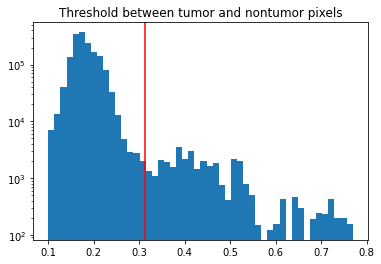

In [8]:
tolerance = 0.1
output = np.zeros(data_flair.shape)
for i in range(0, 155):
    slice_2d = flair_rgb[:,:,i,:]
    maxval = np.max(slice_2d)
#    if maxval > tolerance: #otherwise assume image has no tumor
    n_segments_2d = 300
    slic_mask_2d = skimage.segmentation.slic(slice_2d, n_segments=n_segments_2d, convert2lab=True, start_label=1)
    slice_2d = rgb2gray(slice_2d)
    
    

    
    
    labels2D = np.unique(slic_mask_2d)


    for label in labels2D:
        slice_2d[slic_mask_2d ==label]=np.average(slice_2d[slic_mask_2d ==label])

    output[:,:,i]=slice_2d



cluster_3d_masked = output[output > tolerance]

thresh_3d = threshold_otsu(cluster_3d_masked.flatten())
print(thresh_3d)
plt.figure()
plt.title("Threshold between tumor and nontumor pixels")
plt.hist(cluster_3d_masked.flatten(), bins=50, log=True)
plt.axvline(x=thresh_3d, color="red")
plt.show()




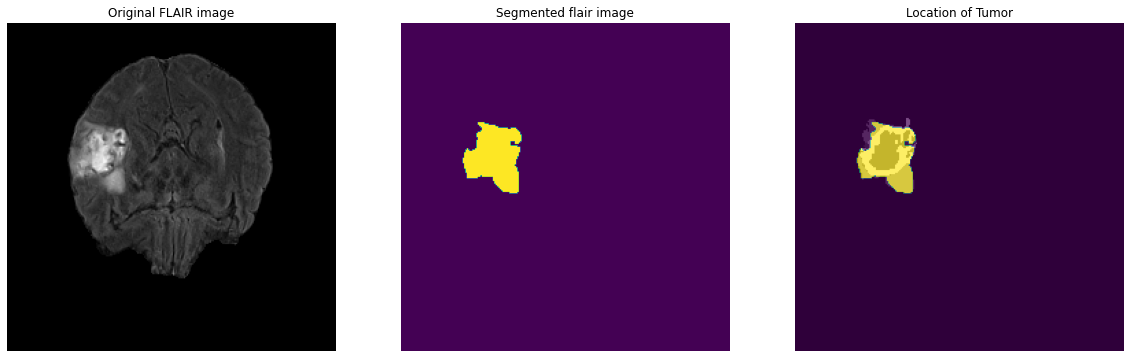

In [9]:
output[output< thresh_3d]=0
tumor_otsu_label = 1
output[output>0]=tumor_otsu_label


plt.figure(figsize=(20,10))

plt.subplot(1,3,1).set_axis_off()
plt.title("Original FLAIR image")
plt.imshow(data_flair[:,:,60].T, cmap="gray", origin='lower')

plt.subplot(1,3,2).set_axis_off()
plt.title("Segmented flair image")
plt.imshow(output[:,:,60].T,  origin='lower')

plt.subplot(1,3,3).set_axis_off()
plt.title("Location of Tumor")

plt.imshow(output[:,:,60].T, origin='lower')
plt.imshow(data_seg[:,:,60].T, alpha = 0.3, cmap="gray", origin='lower')

plt.show()

In [10]:
a = evaluate_segmentation(output.flatten(), data_seg.flatten(), tumor_otsu_label)

True Positive:  0.7430667712611324
False negative:  0.2569332287388676
True Negative:  0.9998539054626526
False Positive:  0.00014609453734741395
'specificity': 0.9612583572110793
Combined TP and Specificity  0.8521625642361059
Dice loss is  0.8381958722640085
Jaccard loss is  0.7214605734767026
************
Total Error:  0.0013926971326164875


In [11]:
b = evaluate_segmentation(output.flatten(), data_seg.flatten(), tumor_otsu_label)

True Positive:  0.7430667712611324
False negative:  0.2569332287388676
True Negative:  0.9998539054626526
False Positive:  0.00014609453734741395
'specificity': 0.9612583572110793
Combined TP and Specificity  0.8521625642361059
Dice loss is  0.8381958722640085
Jaccard loss is  0.7214605734767026
************
Total Error:  0.0013926971326164875


In [12]:
c = evaluate_segmentation(output.flatten(), data_seg.flatten(), tumor_otsu_label)

True Positive:  0.7430667712611324
False negative:  0.2569332287388676
True Negative:  0.9998539054626526
False Positive:  0.00014609453734741395
'specificity': 0.9612583572110793
Combined TP and Specificity  0.8521625642361059
Dice loss is  0.8381958722640085
Jaccard loss is  0.7214605734767026
************
Total Error:  0.0013926971326164875


In [17]:
dct = {'a':a, 'b':b, 'c':c}

In [18]:
dct

{'a': array([7.43066771e-01, 2.56933229e-01, 9.99853905e-01, 1.46094537e-04,
        9.61258357e-01, 8.52162564e-01, 8.38195872e-01, 7.21460573e-01,
        1.39269713e-03]),
 'b': array([7.43066771e-01, 2.56933229e-01, 9.99853905e-01, 1.46094537e-04,
        9.61258357e-01, 8.52162564e-01, 8.38195872e-01, 7.21460573e-01,
        1.39269713e-03]),
 'c': array([7.43066771e-01, 2.56933229e-01, 9.99853905e-01, 1.46094537e-04,
        9.61258357e-01, 8.52162564e-01, 8.38195872e-01, 7.21460573e-01,
        1.39269713e-03])}

In [24]:
pd.DataFrame(dct, index = ["True Positive", "False negative", "True Negative", 
                                      "False positive", "Specificity", "Combined TP and Specificity",
                                      "Dice Loss", "Jaccard Loss", "Total Error"]).transpose()

,True Positive,False negative,True Negative,False positive,Specificity,Combined TP and Specificity,Dice Loss,Jaccard Loss,Total Error
a,0.743067,0.256933,0.999854,0.000146,0.961258,0.852163,0.838196,0.721461,0.001393
b,0.743067,0.256933,0.999854,0.000146,0.961258,0.852163,0.838196,0.721461,0.001393
c,0.743067,0.256933,0.999854,0.000146,0.961258,0.852163,0.838196,0.721461,0.001393


In [13]:
results = np.asarray([a, b, c])
results.shape

(3, 9)

In [14]:
results

array([[7.43066771e-01, 2.56933229e-01, 9.99853905e-01, 1.46094537e-04,
        9.61258357e-01, 8.52162564e-01, 8.38195872e-01, 7.21460573e-01,
        1.39269713e-03],
       [7.43066771e-01, 2.56933229e-01, 9.99853905e-01, 1.46094537e-04,
        9.61258357e-01, 8.52162564e-01, 8.38195872e-01, 7.21460573e-01,
        1.39269713e-03],
       [7.43066771e-01, 2.56933229e-01, 9.99853905e-01, 1.46094537e-04,
        9.61258357e-01, 8.52162564e-01, 8.38195872e-01, 7.21460573e-01,
        1.39269713e-03]])

In [15]:
df = pd.DataFrame(results, columns = ["True Positive", "False negative", "True Negative", 
                                      "False positive", "Specificity", "Combined TP and Specificity",
                                      "Dice Loss", "Jaccard Loss", "Total Error"])
df
    

,True Positive,False negative,True Negative,False positive,Specificity,Combined TP and Specificity,Dice Loss,Jaccard Loss,Total Error
0,0.743067,0.256933,0.999854,0.000146,0.961258,0.852163,0.838196,0.721461,0.001393
1,0.743067,0.256933,0.999854,0.000146,0.961258,0.852163,0.838196,0.721461,0.001393
2,0.743067,0.256933,0.999854,0.000146,0.961258,0.852163,0.838196,0.721461,0.001393


In [16]:
df.to_csv("test.csv")

In [ ]:
def compare_results(results_array):

# T Test value

In [12]:
tumor_hat = (flair_norm[output>0]).flatten()
nontumor_hat = flair_norm[output ==0]
nontumor_hat = nontumor_hat[nontumor_hat> tolerance]

In [13]:
np.mean(tumor_hat)

0.44683124268319313

In [14]:
np.mean(nontumor_hat)

0.1819344853461763

In [15]:
ttest_ind(tumor_hat, nontumor_hat)

Ttest_indResult(statistic=1225.2852429914374, pvalue=0.0)

In [16]:
mean_diff = np.mean(tumor_hat) - np.mean(nontumor_hat)
mean_diff

0.26489675733701684

# T test with cleaned image

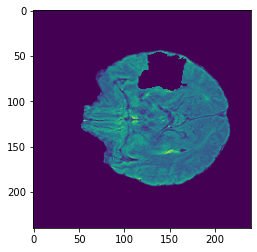

In [17]:
data_flair[data_seg>0]=0
plt.figure()
plt.imshow(data_flair[:,:,60])
plt.show()

In [18]:
#normalize
minval = np.min(data_flair)
maxval = np.max(data_flair)
flair_norm = (data_flair-minval)/(maxval-minval)

#median filter (noise reduction)
flair_norm  = median(flair_norm )

#convert to rGB color space
flair_rgb = gray2rgb(flair_norm )

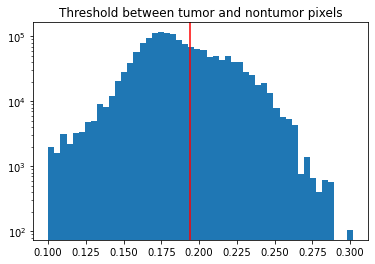

In [19]:
tolerance = 0.1
output = np.zeros(data_flair.shape)
for i in range(0, 155):
    slice_2d = flair_rgb[:,:,i,:]
    maxval = np.max(slice_2d)
    if maxval > tolerance: #otherwise assume image has no tumor
        n_segments_2d = 300
        slic_mask_2d = skimage.segmentation.slic(slice_2d, n_segments=n_segments_2d, start_label=1)
        slice_2d = rgb2gray(slice_2d)
        labels2D = np.unique(slic_mask_2d)
        

        for label in labels2D:
            slice_2d[slic_mask_2d ==label]=np.average(slice_2d[slic_mask_2d ==label])
        output[:,:,i]=slice_2d

         

cluster_3d_masked = output[output > tolerance]

thresh_3d = threshold_otsu(cluster_3d_masked)
plt.figure()
plt.title("Threshold between tumor and nontumor pixels")
plt.hist(cluster_3d_masked.flatten(), bins=50, log=True)
plt.axvline(x=thresh_3d, color="red")
plt.show()




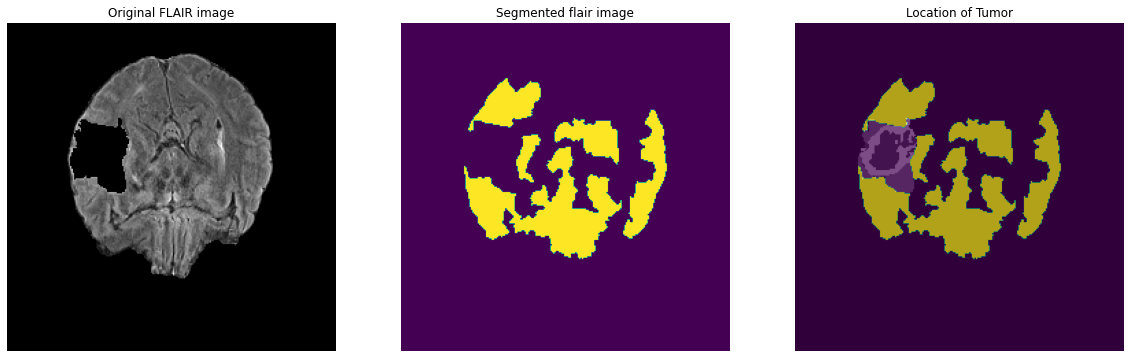

In [20]:
output[output< thresh_3d]=0
tumor_otsu_label = 1
output[output>0]=tumor_otsu_label


plt.figure(figsize=(20,10))

plt.subplot(1,3,1).set_axis_off()
plt.title("Original FLAIR image")
plt.imshow(data_flair[:,:,60].T, cmap="gray", origin='lower')

plt.subplot(1,3,2).set_axis_off()
plt.title("Segmented flair image")
plt.imshow(output[:,:,60].T,  origin='lower')

plt.subplot(1,3,3).set_axis_off()
plt.title("Location of Tumor")

plt.imshow(output[:,:,60].T, origin='lower')
plt.imshow(data_seg[:,:,60].T, alpha = 0.3, cmap="gray", origin='lower')

plt.show()

In [21]:
tumor_hat = (flair_norm[output>0]).flatten()
nontumor_hat = flair_norm[output ==0]
nontumor_hat = nontumor_hat[nontumor_hat> tolerance]

In [22]:
np.mean(tumor_hat)

0.21732506112438293

In [23]:
np.std(tumor_hat)

0.035631273420600976

In [24]:
np.mean(nontumor_hat)

0.17287204797057515

In [25]:
np.std(nontumor_hat)

0.025977374595761164

In [26]:
ttest_ind(tumor_hat, nontumor_hat, equal_var=False)

Ttest_indResult(statistic=830.5226930972153, pvalue=0.0)

In [27]:
mean_diff = np.mean(tumor_hat) - np.mean(nontumor_hat)
mean_diff

0.044453013153807786